<div style="text-align: center;">
    <h1 style="font-size: 20px;">
        Final project for the <strong style="font-size: 26px;"> MAPD-B </strong> course<br>
        <strong style="font-size: 35px; display: block; margin-top: 20px;">4 - Batch analysis of cosmic rays using Drift Tubes detectors</strong>
    </h1>
</div>

<hr style="border: 1px solid #000;">

<!-- Adjusted container for images -->
<div style="display: flex; justify-content: center; align-items: center; flex-wrap: wrap; gap: 20px;">
    <img src="unipd_template.png" alt="Unipd template" style="max-width: 300px; height: auto; margin: 0;">
    <img src="pod_template.png" alt="PoD template" style="max-width: 200px; height: auto; margin: 0;">
</div>

<hr style="border: 1px solid #000;">

<!-- Container for text and table -->
<div style="text-align: left; margin: 0 auto; width: 80%;">
    <p><strong>Degree:</strong> Physics of Data</p>
    <p><strong>Course:</strong> Management and Analysis of Physics Dataset (mod.B)</p>
    <p><strong>Year:</strong> 2023-2024</p>
    <p><strong>Teacher:</strong> prof. Jacopo Pazzini</p>
    <table style="margin: 20px auto; border-collapse: collapse; width: 100%; font-size: 12px; text-align: left;">
        <thead>
            <tr>
                <th colspan="3" style="border: none; padding: 6px; text-align: center; font-weight: bold; font-size: 15px">Group 9 students</th>
            </tr>
            <tr>
                <th style="border-bottom: 1px solid #000; padding: 6px;">Name</th>
                <th style="border-bottom: 1px solid #000; padding: 6px;">ID</th>
                <th style="border-bottom: 1px solid #000; padding: 6px;">Email</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td style="padding: 6px;">Ginevra Beltrame</td>
                <td style="padding: 6px;">2130668</td>
                <td style="padding: 6px;">ginevra.beltrame@studenti.unipd.it</td>
            </tr>
            <tr>
                <td style="padding: 6px;">Emanuele Coradin</td>
                <td style="padding: 6px;">2124732</td>
                <td style="padding: 6px;">emanuele.coradin@studenti.unipd.it</td>
            </tr>
            <tr>
                <td style="padding: 6px;">Arina Ponomareva</td>
                <td style="padding: 6px;">2106897</td>
                <td style="padding: 6px;">arina.ponomareva@studenti.unipd.it</td>
            </tr>
            <tr>
                <td style="padding: 6px;">Margarita Shnaider</td>
                <td style="padding: 6px;">2107523</td>
                <td style="padding: 6px;">margarita.shnaider@studenti.unipd.it</td>
            </tr>
        </tbody>
    </table>
</div>


<div style="text-align: center;">
    <h1 style="font-size: 20px;">
        <strong style="font-size: 35px; display: block; margin-top: 20px;">Part 1 - Data Analysis</strong>
    </h1>
</div>

#### Imports

In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
import struct, time
import dask
from dask.distributed import Client
from dask.distributed import SSHCluster
from dask.distributed import LocalCluster # local cluster setup (temporary)

import pandas as pd
import numpy as np
import itertools

from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import dask.dataframe as dd 
import dask.array as da
from dask.delayed import delayed
import dask.bag as db

import graphviz

import matplotlib.pyplot as plt
import matplotlib.patches as patches

dask.config.set({'dataframe.query-planning':True}) # activates an SQL-based efficient optimization of the queries in dataframes

#### Global variables

In [2]:
# Useful global variables

MAX_HIT_ORB  = 20
MIN_HIT_ORB = 6
MIN_HITS_PER_CHAMBER = 3

hreg = HuberRegressor(max_iter=30, epsilon=1.05, tol=1e-4)
CELL_WIDTH  = 42
CELL_HEIGHT = 13

n_partitions = 48

time_offset_by_chamber = {
    0: 95.0 - 1.1, # Ch 0
    1: 95.0 + 6.4, # Ch 1
    2: 95.0 + 0.5, # Ch 2
    3: 95.0 - 2.6, # Ch 3
}

start = time.time()

V_DRIFT = 53.8e-3 # µm/ns = 10^-3 mm/ns

#### Dataframe structure setup

In [3]:
fpga_column = np.array([np.zeros(128), np.ones(128)], dtype=np.int32).flatten()
tdc_column = np.hstack((np.arange(0, 128), np.arange(0, 128)))
chamber_column = np.array([np.zeros(64), np.ones(64), 2*np.ones(64), 3*np.ones(64)], dtype=np.int32).flatten()
z_column = np.array([219.8*np.ones(64), 977.3*np.ones(64), 1035.6*np.ones(64), 1819.8*np.ones(64)]).flatten()

dict_bricks = {
    'FPGA' : fpga_column,
    'TDC_CHANNEL': tdc_column,
    'Chamber': chamber_column,
    'x' : np.zeros(256),
    'y' : np.zeros(256),
    'z' : z_column,
}

df_bricks = pd.DataFrame(dict_bricks)

z_list = 13*np.array([7/2, 3/2, 5/2, 1/2])
indices = df_bricks['TDC_CHANNEL'] % 4
z_addition = indices.map(lambda idx: z_list[idx])

df_bricks['z'] = df_bricks['z'] + z_addition
df_bricks.loc[df_bricks['Chamber'].isin([0, 2, 3]), 'x'] = df_bricks['x'] + 21 * ((df_bricks['TDC_CHANNEL']%64) // 2) + 21
df_bricks.loc[df_bricks['Chamber'].isin([1]), 'y'] = df_bricks['y'] + 21 * ((df_bricks['TDC_CHANNEL']%64) // 2)

#df_bricks

#### Processing functions definition

In [4]:
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

def read_file(filename):
    client_kwargs = {
        'endpoint_url': 'https://cloud-areapd.pd.infn.it:5210',
        'verify': False
    }
    
    # Read bytes from the specified S3 bucket with the given credentials and client configurations
    sample, blocks = dask.bytes.read_bytes(
        filename,
        key='#########',
        secret='#########',
        client_kwargs=client_kwargs
    )
    df_chuncks = [convert_bytes(block[0]) for block in blocks]
    df = dd.from_delayed(df_chuncks)
    return df

#___________________________________________________________________________________________________________________________________
@dask.delayed
def convert_bytes(byte_file):
    word_size = 8
    head_number = 2

    # Convert byte file to a numpy array of integers
    # obs: 8 byte words can be stored into int64
    byte_array = np.frombuffer(byte_file, dtype=np.uint64)
    
    # Extract fields
    head = (byte_array >> 61) & 0x7
    fpga = (byte_array >> 58) & 0x7
    tdc_chan = (byte_array >> 49) & 0x1FF
    orb_cnt = (byte_array >> 17) & 0xFFFFFFFF
    bx = (byte_array >> 5) & 0xFFF
    tdc_meas = (byte_array >> 0) & 0x1F

    mask = (head == head_number)

    data = {
        'FPGA': fpga[mask],
        'TDC_CHANNEL': tdc_chan[mask],
        'ORB_CNT': orb_cnt[mask],
        'BX': bx[mask],
        'TDC_MEAS': tdc_meas[mask]
    }
    
    return pd.DataFrame(data)

#___________________________________________________________________________________________________________________________________
def assign_chamber(row):
    if row['FPGA'] == 0:
        if 0 <= row['TDC_CHANNEL'] <= 63:
            return 0
        elif 64 <= row['TDC_CHANNEL'] <= 127:
            return 1
    elif row['FPGA'] == 1:
        if 0 <= row['TDC_CHANNEL'] <= 63:
            return 2
        elif 64 <= row['TDC_CHANNEL'] <= 128:
            return 3
    return -1

#___________________________________________________________________________________________________________________________________
def filter_groups_part1(df):
    # Filter with scintillator's information
    scintillator_df = df[(df.FPGA == 1) & (df.TDC_CHANNEL == 128)].drop_duplicates(subset='ORB_CNT', keep='first')
    scintillator_df['t0'] = 25 * (scintillator_df['BX'] + scintillator_df['TDC_MEAS'] / 30)
    scintillator_df = scintillator_df[['ORB_CNT', 't0']]
    
    # Remove scintillator info from the main DataFrame
    df = df[df.TDC_CHANNEL < 128]

    df = df.merge(scintillator_df, on='ORB_CNT', how='inner')
    return df

#___________________________________________________________________________________________________________________________________
def threshold_analysis(threshold, low_filter, df):
    df_grouped = df.groupby('ORB_CNT')['FPGA'].count()
    orbits_to_drop = df_grouped[(df_grouped > threshold) | (df_grouped < low_filter)].index
    print('orbits to drop: ', len(orbits_to_drop), '/', len(df_grouped.index))

    # Set bins to be integers to remove spaces between bins
    bins = np.arange(df_grouped.min(), df_grouped.max() + 1, 1)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.hist(df_grouped, bins=bins, color='lightskyblue', align='mid', edgecolor='royalblue')
    ax.set_xlabel('Hits per orbit')
    ax.set_ylabel('Counts')
    ax.set_xlim(0, 75)
    ax.axvline(x=threshold, color='r', linestyle='--', linewidth=1)
    ax.axvline(x=low_filter, color='firebrick', linestyle='--', linewidth=1)
    
    plt.show()
    
#___________________________________________________________________________________________________________________________________
def filter_groups_part2_a(df):    
    # Assign chamber information
    df['Chamber'] = df.apply(assign_chamber, axis=1, meta=('Chamber', 'float64'))
    
    # Add further information
    df['relative_time'] = 25 * (df['BX'] + df['TDC_MEAS'] / 30)
    df = df.drop(columns=['BX', 'TDC_MEAS'])
    
    # Calculate relative time by subtracting t0
    df['relative_time'] = df['relative_time'] - df['t0']
    df = df.drop(columns=['t0'])

    # Add time offsets based on the chamber
    df['relative_time'] = df['relative_time'] + df['Chamber'].map(time_offset_by_chamber)

    # Calculate x_left and x_right positions based on the drift velocity
    df['x_left']  = - V_DRIFT*df['relative_time']
    df['x_right'] = + V_DRIFT*df['relative_time']
    df['z'] = 0

    # Drop non-physical positions
    df = df[(df.x_left.between(-CELL_WIDTH/2, 0)) & (df.x_right.between(0, CELL_WIDTH/2))]

    return df
    
#___________________________________________________________________________________________________________________________________
def filter_groups_part2_b(df):    
    # Drop events based on number of hits
   
    #Remove hits of chambers with less than MIN_HITS_PER_CHAMBER hits
    grouped = df.groupby(['ORB_CNT', 'Chamber']).filter(lambda x: len(x) >= MIN_HITS_PER_CHAMBER)
    df = df.loc[df.ORB_CNT.isin(grouped.ORB_CNT)]

    # Remove events based on total number of hits
    grouped = df.groupby('ORB_CNT').filter(lambda x: MIN_HIT_ORB <= len(x) <= MAX_HIT_ORB)
    df = df.loc[df.ORB_CNT.isin(grouped.ORB_CNT)]

    # Create a mask for Chamber 1
    mask_chamber_1 = (df['Chamber'] == 1)
    
    # For Chambers other than 1, adjust x_left and x_right positions
    df.loc[~mask_chamber_1, 'x_left']  = df.loc[~mask_chamber_1, 'x_left']  + df_bricks.loc[(df.loc[~mask_chamber_1, 'Chamber']//2)*128 + df.loc[~mask_chamber_1, 'TDC_CHANNEL'], 'x'].values
    df.loc[~mask_chamber_1, 'x_right'] = df.loc[~mask_chamber_1, 'x_right'] + df_bricks.loc[(df.loc[~mask_chamber_1, 'Chamber']//2)*128 + df.loc[~mask_chamber_1, 'TDC_CHANNEL'], 'x'].values
    
    # For Chamber 1, adjust x_left and x_right positions
    df.loc[mask_chamber_1, 'x_left']  = df.loc[mask_chamber_1, 'x_left']  + df_bricks.loc[(df.loc[mask_chamber_1, 'Chamber']//2)*128 + df.loc[mask_chamber_1, 'TDC_CHANNEL'], 'y'].values
    df.loc[mask_chamber_1, 'x_right'] = df.loc[mask_chamber_1, 'x_right'] + df_bricks.loc[(df.loc[mask_chamber_1, 'Chamber']//2)*128 + df.loc[mask_chamber_1, 'TDC_CHANNEL'], 'y'].values
    
    # Adjust z positions based on the bricks information
    df['z'] = df['z'] + df_bricks.loc[(df['Chamber']//2)*128 + df['TDC_CHANNEL'], 'z'].values

    return df

#___________________________________________________________________________________________________________________________________
def fit_tracks_vectorized(group):
    
    x_left = group['x_left'].values
    x_right = group['x_right'].values
    z = group['z'].values
    chamber = group['Chamber'].values[0]
    orb_cnt = group['ORB_CNT'].values[0]

    # Group the data by 'z' to ensure we are considering all combinations of points with the same z
    grouped_by_z = group.groupby('z')

    # List to store all combinations of x-values for different z values
    x_combinations = []
    list_stacks = []

    # Loop through each unique z value and get combinations of x_left and x_right
    for z_value, sub_group in grouped_by_z:
        x_left_sub = sub_group['x_left'].values
        x_right_sub = sub_group['x_right'].values

        # Stack left and right x-values for this z
        stack = np.column_stack((x_left_sub, x_right_sub)).flatten()
        list_stacks.append(stack)

    # Use numpy.meshgrid to create a multi-dimensional grid
    meshgrid_result = np.meshgrid(*list_stacks, indexing='ij')

    # Reshape and flatten the resulting arrays into a list of combinations
    x_combinations = np.array([grid.ravel() for grid in meshgrid_result]).T
    x_combinations_all = np.vstack(x_combinations)
    z_rows = np.sort(np.unique(group['z']))

    # Matrix for least squares: z-values and a column of ones for the intercept term
    A = np.vstack((z_rows, np.ones(len(z_rows)))).T

    # Perform least-squares fit on all combinations at once
    coeffs, residuals, _, _ = np.linalg.lstsq(A, x_combinations_all.T, rcond=None)

    # Compute chi-squared/ndof for all combinations
    chi_squared_ndof = residuals / (len(z_rows) - 2)  # Adjust degrees of freedom
    
    if chi_squared_ndof.size == 0:
        #print(f"Empty chi_squared_ndof for Chamber {chamber}, ORB_CNT {orb_cnt}")
        return None

    # Find the combination with the least chi-squared/ndof
    best_fit_idx = np.argmin(chi_squared_ndof)
    best_x = x_combinations_all[best_fit_idx]

    # Extract the best coefficients and intercept for the best fit
    reg_coef = coeffs[0][best_fit_idx]
    reg_intercept = coeffs[1][best_fit_idx]

    # Return a DataFrame with the fit results
    new_row = pd.DataFrame({
        'Chamber_': [chamber],
        'ORB_CNT_': [orb_cnt],
        'x_values': [best_x],
        'z_values': [z_rows],
        'Reg_Coefficient': [reg_coef],
        'Reg_Intercept': [reg_intercept],
        'Chi_Squared_NDOF': [chi_squared_ndof[best_fit_idx]]
    })

    return new_row
     
#___________________________________________________________________________________________________________________________________

def fit_global_tracks(group):
    orb_cnt = group['ORB_CNT'].values[0]
    group = group[group['Chamber'].isin([0, 2, 3])]
    
    if group.empty or len(group) < 2:  # Need at least 2 points for a fit
        new_row =  pd.DataFrame({
            'ORB_CNT_': [orb_cnt],
            'Reg_Coefficient': [np.nan],
            'Reg_Intercept':   [np.nan],
            'Chi_Squared_NDOF': [np.nan]
        })
        return new_row
        
    x  = np.concatenate(group['x_values'].values)
    z  = np.concatenate(group['z_values'].values).T
    
    try:
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always", ConvergenceWarning)
            
            A = np.vstack((z, np.ones(len(z)))).T

            coeffs, residual, _, _ = np.linalg.lstsq(A, x.T, rcond=None)
            global_slope = coeffs[0]
            global_intercept = coeffs[1]
            
            chi_squared_ndof = residual / (len(z) - 2)
            
            if chi_squared_ndof.size == 0:
                return None
    
            new_row = pd.DataFrame({
                'ORB_CNT_': [orb_cnt],
                'Reg_Coefficient': [global_slope],
                'Reg_Intercept': [global_intercept],
                'Chi_Squared_NDOF': [chi_squared_ndof[0]]
            })
    
            # Check if any ConvergenceWarnings were raised
            if any(issubclass(warning.category, ConvergenceWarning) for warning in w):
                raise RuntimeError("Convergence warning captured: Increase the number of iterations (max_iter) or scale the data as shown in: https://scikit-learn.org/stable/modules/preprocessing.html")
    
    except (ValueError, RuntimeError) as e:
        new_row = pd.DataFrame({
            'ORB_CNT_': [orb_cnt],
            'Reg_Coefficient': [np.nan],
            'Reg_Intercept': [np.nan],
            'Chi_Squared_NDOF': [np.nan]
        })
    return new_row


#### Plotting functions definitions

In [5]:
def plot_hit_counts(chambers, df_res, df_bricks):
    TDC_counts = df_res[df_res['TDC_CHANNEL'] < 128]
    TDC_counts['TDC_unique'] = 128 * TDC_counts['FPGA'] + TDC_counts['TDC_CHANNEL']
    TDC_counts = TDC_counts.groupby('TDC_unique').count().iloc[:, [1]].rename(columns={'TDC_CHANNEL': 'Counts'})
    
    fig, axes = plt.subplots(len(chambers), 1, figsize=(12, 10 * len(chambers) / 3))
    axes = axes.flatten()
    
    # Create normalization and colormap
    norm = plt.Normalize(np.min(TDC_counts['Counts']), np.max(TDC_counts['Counts']))
    cmap = plt.cm.plasma
    
    # Create ScalarMappable for colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # For the colorbar to have a reference
    
    for i, chamber in enumerate(chambers):
        ax = axes[i]
        bricks_data = df_bricks[df_bricks['Chamber'] == chamber]
        if chamber == 1:  # using 'y' for scatter plot in chamber 1
            ax.scatter(bricks_data['y'], bricks_data['z'], color='red', label='wire', marker='.')
            for index, row in bricks_data.iterrows():
                # Default color to a neutral one if the index is missing
                color = cmap(norm(0))
                if index in TDC_counts.index:
                    color = cmap(norm(TDC_counts.loc[index, 'Counts']))
                rect = patches.Rectangle((row['y'] - CELL_WIDTH / 2, row['z'] - CELL_HEIGHT / 2),
                                         CELL_WIDTH, CELL_HEIGHT, linewidth=1, edgecolor='gray', facecolor=color)
                ax.add_patch(rect)
        else:
            ax.scatter(bricks_data['x'], bricks_data['z'], color='red', label='wire', marker='.')
            for index, row in bricks_data.iterrows():
                color = cmap(norm(0))
                if index in TDC_counts.index:
                    color = cmap(norm(TDC_counts.loc[index, 'Counts']))
                rect = patches.Rectangle((row['x'] - CELL_WIDTH / 2, row['z'] - CELL_HEIGHT / 2),
                                         CELL_WIDTH, CELL_HEIGHT, linewidth=1, edgecolor='gray', facecolor=color)
                ax.add_patch(rect)
        
        ax.set_title(f'Chamber {chamber}')
        ax.set_xlabel('x' if chamber != 1 else 'y')
        ax.set_ylabel('z')
        
        # Add colorbar
        cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
        cbar.set_label('Counts')
    
    plt.tight_layout()
    plt.show()

#___________________________________________________________________________________________________________________________________
def plot_local_fit(df_local_fit, df_hits, n_orbit):
    
    df_hits = df_hits[df_hits['ORB_CNT']==n_orbit]
    df_local_fit = df_local_fit[df_local_fit['ORB_CNT']==n_orbit]
    
    chambers = df_local_fit['Chamber'].unique()
    chambers = chambers[chambers != 1]
    chambers_idxs = np.argsort(chambers)[::-1]
    chambers = chambers[chambers_idxs]
    
    fig, axes = plt.subplots(len(chambers), 1, figsize=(12, 10*len(chambers)/3))
    fig.suptitle('Local fit plot, ORB_CNT=' + str(n_orbit), fontsize=16)
    axes = axes.flatten()
    
    for i, chamber in enumerate(chambers):
        ax = axes[i]
        chamber_data = df_hits[df_hits['Chamber'] == chamber]
        bricks_data  = df_bricks[df_bricks['Chamber'] == chamber]

        regression_chamber = df_local_fit[df_local_fit['Chamber'] == chamber]
        
        reg_intercept = regression_chamber['Reg_Intercept'].iloc[0]
        reg_coefficient = regression_chamber['Reg_Coefficient'].iloc[0]
        x_values = np.linspace(bricks_data['z'].min()-20, bricks_data['z'].max()+20, 100)
        y_values = reg_coefficient * x_values + reg_intercept

        if chamber == 1:  # using 'y' for scatter plot in chamber 1
            ax.scatter(bricks_data['y'], bricks_data['z'], color='red', label='wire', marker='.')
            for index, row in bricks_data.iterrows():
                rect = patches.Rectangle((row['y'] - CELL_WIDTH/2, row['z'] - CELL_HEIGHT/2), 
                                         CELL_WIDTH, CELL_HEIGHT, linewidth=1, edgecolor='gray', facecolor='none', alpha=0.5)
                ax.add_patch(rect)
        else:  # using 'x' for other chambers
            ax.scatter(bricks_data['x'], bricks_data['z'], color='red', label='wire', marker='.')
            for index, row in bricks_data.iterrows():
                rect = patches.Rectangle((row['x'] - CELL_WIDTH/2, row['z'] - CELL_HEIGHT/2), 
                                         CELL_WIDTH, CELL_HEIGHT, linewidth=1, edgecolor='gray', facecolor='none', alpha=0.9)
                ax.add_patch(rect)
            
        ax.scatter(chamber_data['x_left'], chamber_data['z'], color='blue', label='x_left')
        ax.scatter(chamber_data['x_right'], chamber_data['z'], color='orange', label='x_right')
        ax.scatter(np.concatenate(regression_chamber['x_values'].values), np.concatenate(regression_chamber['z_values'].values), color='lightgreen', label='choice', marker = 'o')
        
        ax.plot(y_values, x_values, color='green', label='Fit Line')
        ax.set_title(f'Chamber {chamber}')
        ax.set_xlabel('x')
        ax.set_ylabel('z')
        ax.legend()
    
    plt.tight_layout()
    plt.show()


#___________________________________________________________________________________________________________________________________

def plot_global_fit(df_global_fit, df_hits, n_orbit, df_bricks):
    
    df_hits = df_hits[df_hits['ORB_CNT']==n_orbit]
    df_global_fit = df_global_fit[df_global_fit['ORB_CNT']==n_orbit]

    fig, ax = plt.subplots(1, 1, figsize=(12, 7.5))
    fig.suptitle('Global fit plot, ORB_CNT=' + str(n_orbit), fontsize=16)

    chambers = [3, 2, 0]
    for ch_idx, chamber in enumerate(chambers):
        chamber_data = df_hits[df_hits['Chamber'] == chamber]
        bricks_data = df_bricks[df_bricks['Chamber'] == chamber]

        for index, row in bricks_data.iterrows():
            rect = patches.Rectangle((row['x'] - CELL_WIDTH/2, row['z'] - CELL_HEIGHT/2), 
                                     CELL_WIDTH, CELL_HEIGHT, linewidth=1, edgecolor='gray', facecolor='none', alpha=0.9)
            ax.add_patch(rect)

        if 'x_left' in chamber_data.columns and 'x_right' in chamber_data.columns:
            if ch_idx == 0:
                ax.scatter(chamber_data['x_left'], chamber_data['z'], color='blue', label='x_left')
                ax.scatter(chamber_data['x_right'], chamber_data['z'], color='orange', label='x_right')
            else:
                ax.scatter(chamber_data['x_left'], chamber_data['z'], color='blue')
                ax.scatter(chamber_data['x_right'], chamber_data['z'], color='orange')
        else:
            print(f"Columns 'x_left' or 'x_right' not found in chamber {chamber} data.")
            continue


    if not df_global_fit.empty:
        global_intercept = df_global_fit['Reg_Intercept'].iloc[0]
        global_slope = df_global_fit['Reg_Coefficient'].iloc[0]
        
        z_values = np.linspace(df_hits['z'].min(), df_hits['z'].max(), 100)
        x_values = global_slope * z_values + global_intercept
        ax.plot(x_values, z_values, color='green', label='Global Fit Line')

        ax.set_title('Global fit')
        ax.set_xlabel('x')
        ax.set_ylabel('z')
    
    ax.legend(loc=(0.85, 0.75))
    plt.tight_layout()
    plt.show()


#### Client setup

In [6]:
# Uncomment to setup a distributed cluster
n_workers = 4
nthreads  = 1

cluster = SSHCluster(
    ["10.67.22.142", "10.67.22.142", "10.67.22.209", "10.67.22.80"],
    worker_options={"nthreads": nthreads, "n_workers": n_workers},
    scheduler_options={"port": 8786, "dashboard_address": ":8787"},
    connect_options={
        "known_hosts": "/home/coradin/.ssh/known_hosts",
        "username": "coradin"
    },
    remote_python="/miniconda3/envs/DASK/bin/python",
    
)

client = Client(cluster, timeout='180s')
client.wait_for_workers(n_workers)

2024-09-19 10:25:58,204 - distributed.deploy.ssh - INFO - 2024-09-19 10:25:58,203 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-09-19 10:25:58,224 - distributed.deploy.ssh - INFO - 2024-09-19 10:25:58,223 - distributed.scheduler - INFO - State start
2024-09-19 10:25:58,225 - distributed.deploy.ssh - INFO - 2024-09-19 10:25:58,224 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-f5y5oet7', purging
2024-09-19 10:25:58,225 - distributed.deploy.ssh - INFO - 2024-09-19 10:25:58,224 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-nedomrof', purging
2024-09-19 10:25:58,225 - distributed.deploy.ssh - INFO - 2024-09-19 10:25:58,224 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-y_oqfh98', purging
2024-09-19 10:25:58,226 - di

In [7]:
client

<Client: 'tcp://10.67.22.142:8786' processes=4 threads=4, memory=7.75 GiB>

# Reduced dataset analysis (10 files)

## Preprocessing

### Threshold analysis

orbits to drop:  391 / 6327


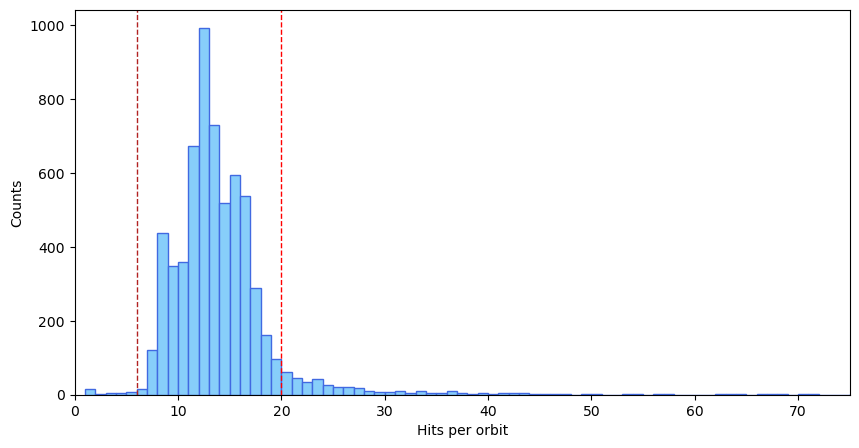

In [8]:
filename = 's3://project-bkp/data_00000*'

df = read_file(filename)
df = df.map_partitions(filter_groups_part1)
threshold_analysis(MAX_HIT_ORB, MIN_HIT_ORB, df.compute())

In [9]:
df = filter_groups_part2_a(df)
df_c = df.map_partitions(filter_groups_part2_b).compute()
df_c

/home/coradin/miniconda3/envs/DASK/lib/python3.12/site-packages/dask_expr/_collection.py:4160: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Chamber', 'float64'))

  warnings.warn(meta_warning(meta))


,FPGA,TDC_CHANNEL,ORB_CNT,Chamber,relative_time,x_left,x_right,z
35,1,91,1118948,3,34.066667,292.167213,295.832787,1826.3
36,0,107,1118948,1,127.233333,434.154847,447.845153,983.8
37,1,47,1118948,2,104.666667,498.368933,509.631067,1042.1
38,1,88,1118948,3,171.566667,263.769713,282.230287,1865.3
39,1,44,1118948,2,101.333333,477.548267,488.451733,1081.1
...,...,...,...,...,...,...,...,...
8466,0,108,48580108,1,282.233333,446.815847,477.184153,1022.8
8467,0,105,48580108,1,304.733333,403.605347,436.394653,996.8
8468,1,40,48580108,2,241.333333,428.016267,453.983733,1081.1
8469,1,38,48580108,2,256.333333,406.209267,433.790733,1068.1


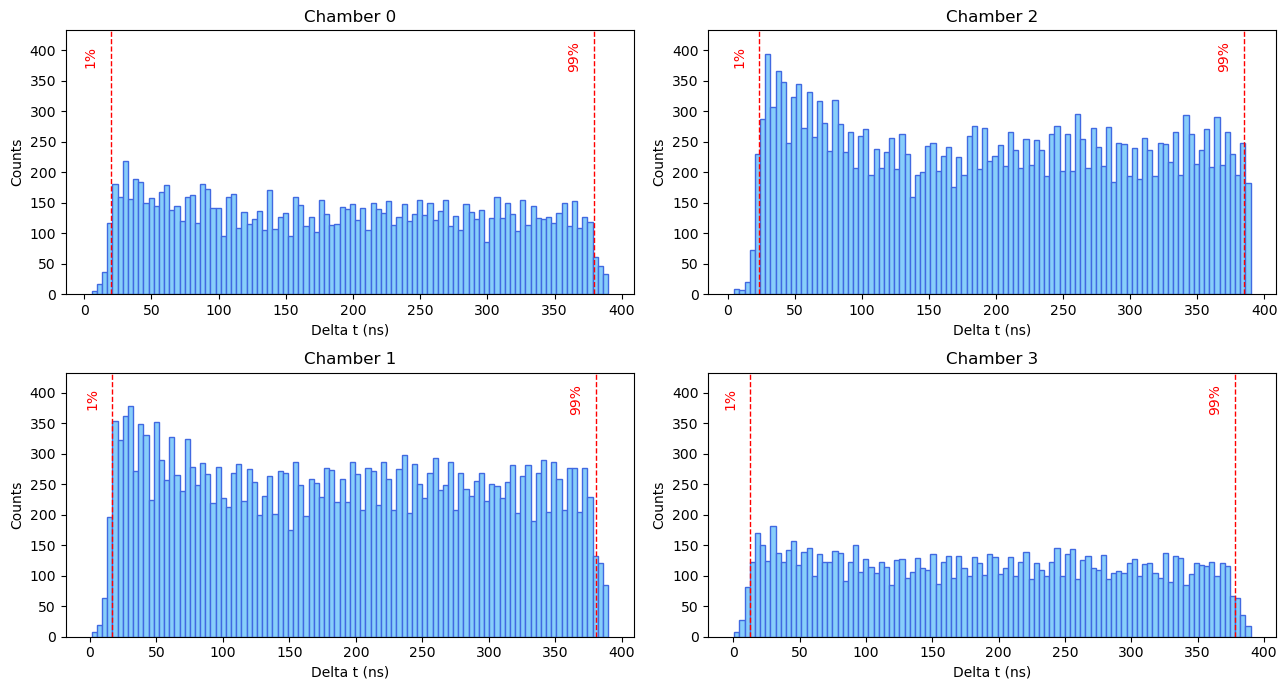

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(13, 7))

df0 = df_c[df_c['Chamber'] == 0]
df1 = df_c[df_c['Chamber'] == 1]
df2 = df_c[df_c['Chamber'] == 2]
df3 = df_c[df_c['Chamber'] == 3]

bin_number = 100

ax[0,0].hist(df0['relative_time'], bins=bin_number, color='lightskyblue', align='mid', edgecolor='royalblue')
ax[0,1].hist(df1['relative_time'], bins=bin_number, color='lightskyblue', align='mid', edgecolor='royalblue')
ax[1,0].hist(df2['relative_time'], bins=bin_number, color='lightskyblue', align='mid', edgecolor='royalblue')
ax[1,1].hist(df3['relative_time'], bins=bin_number, color='lightskyblue', align='mid', edgecolor='royalblue')

# Create histograms and calculate the maximum y values (counts)
counts0, bins0 = np.histogram(df0['relative_time'], bins=bin_number)
counts1, bins1 = np.histogram(df1['relative_time'], bins=bin_number)
counts2, bins2 = np.histogram(df2['relative_time'], bins=bin_number)
counts3, bins3 = np.histogram(df3['relative_time'], bins=bin_number)

# Define the custom quantiles you want to calculate
quantile_percentages = [0.01, 0.99]
# Calculate the quantiles for the relative_time column
quantiles = np.asarray([df0['relative_time'].quantile(quantile_percentages), df1['relative_time'].quantile(quantile_percentages), df2['relative_time'].quantile(quantile_percentages), df3['relative_time'].quantile(quantile_percentages)]).reshape(2,2,2)

for k in [0,1]:
    for j in [0,1]:
        ax[k,j].set_title('Chamber ' + str(k+2*j))
        ax[k,j].set_xlabel('Delta t (ns)')
        ax[k,j].set_ylabel('Counts')
        ax[k,j].set_ylim(0,1.1*max(counts0.max(), counts1.max(), counts2.max(), counts3.max()))
        for i, quantile_value in enumerate(quantiles[k,j]):
            ax[k,j].axvline(x=quantile_value, color='red', linestyle='--', linewidth=1)
            ax[k,j].text(quantile_value-20, ax[k,j].get_ylim()[1] * 0.9, f'{quantile_percentages[i]*100:.0f}%', color='red', rotation=90, verticalalignment='center')

plt.tight_layout()
plt.show()

In [11]:
orbits_20_counts = df_c.groupby('ORB_CNT').filter(lambda x: len(x) == 20)
print(orbits_20_counts['ORB_CNT'].unique())

[ 1582521  3525744  4729678  8333222 11664763 11906697 12574812 12726330
 13872595 18207447 20795838 27231605 30566730 31230665 31483440 31875500
 31963073 36205877 37440832 38052590 38814764 38987540 40341838 42936868
 43764497 44248147 44464805 45263849 47802007 47942471 48074183 48545828]


### Reading and filtering

In [12]:
filename = 's3://project-bkp/data_00000*'

df = read_file(filename)
df = df.map_partitions(filter_groups_part1)
df = filter_groups_part2_a(df)
df = df.map_partitions(filter_groups_part2_b)
#df.visualize(True)

/home/coradin/miniconda3/envs/DASK/lib/python3.12/site-packages/dask_expr/_collection.py:4160: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('Chamber', 'float64'))

  warnings.warn(meta_warning(meta))


## Local Fit

In [13]:
meta = pd.DataFrame({
    'Chamber_': pd.Series(dtype='int64'),
    'ORB_CNT_': pd.Series(dtype='uint64'),
    'x_values': pd.Series(dtype='object'),
    'z_values': pd.Series(dtype='object'),
    'Reg_Coefficient': pd.Series(dtype='float64'),
    'Reg_Intercept': pd.Series(dtype='float64'),
    'Chi_Squared_NDOF': pd.Series(dtype='float64')
})

df_regression = df.map_partitions(
    lambda partition: (
        partition
        .groupby(['Chamber', 'ORB_CNT'])
        .apply(fit_tracks_vectorized, include_groups=True)
    ), 
    meta=meta).reset_index(drop=True).rename(columns={'Chamber_': 'Chamber', 'ORB_CNT_': 'ORB_CNT'})

#df_regression.visualize(True)

## Global fit

In [14]:
meta = pd.DataFrame({
    'ORB_CNT_': pd.Series(dtype='uint64'),
    'Reg_Coefficient': pd.Series(dtype='float64'),
    'Reg_Intercept':   pd.Series(dtype='float64'),
    'Chi_Squared_NDOF': pd.Series(dtype='float64'),
    # 'Reg_Coefficient_loc':   pd.Series(dtype='float64')
})

global_tracks_df = df_regression.map_partitions(
    lambda partition: (
        partition
        .groupby(['ORB_CNT'])
        .apply(fit_global_tracks, include_groups=True)   
    ), 
    meta=meta).dropna().reset_index(drop=True).rename(columns={'ORB_CNT_': 'ORB_CNT'})

#global_tracks_df.visualize(True)


In [15]:
%%time

global_fit_df = global_tracks_df.compute()

global_fit_df.head()

CPU times: user 109 ms, sys: 567 μs, total: 110 ms
Wall time: 5.21 s


,ORB_CNT,Reg_Coefficient,Reg_Intercept,Chi_Squared_NDOF
0,1118948,-0.262812,772.409738,0.260344
1,1123056,0.077788,441.086896,0.759312
2,1124284,-0.057558,486.015703,0.313131
3,1126947,0.091026,355.219645,0.521112
4,1130581,0.199468,285.058922,102.047355


## Plotting

In [16]:
%%time
df_res = df.compute()
n_orbit = 8333222   

df_res[df_res['ORB_CNT'] == n_orbit]

CPU times: user 67.8 ms, sys: 4.51 ms, total: 72.3 ms
Wall time: 1.89 s


,FPGA,TDC_CHANNEL,ORB_CNT,Chamber,relative_time,x_left,x_right,z
4629,1,46,8333222,2,59.666667,500.789933,507.210067,1068.1
4630,1,114,8333222,3,173.233333,536.680047,555.319953,1852.3
4631,1,47,8333222,2,32.166667,502.269433,505.730567,1042.1
4632,0,42,8333222,0,62.233333,458.651847,465.348153,252.3
4633,0,113,8333222,1,116.400000,497.737680,510.262320,996.8
4634,0,27,8333222,0,228.900000,281.685180,306.314820,226.3
4635,0,115,8333222,1,87.233333,520.306847,529.693153,983.8
4636,0,30,8333222,0,279.733333,320.950347,351.049653,252.3
4637,0,43,8333222,0,88.066667,457.262013,466.737987,226.3
4638,0,112,8333222,1,173.066667,494.689013,513.310987,1022.8


### Hit counts per channel

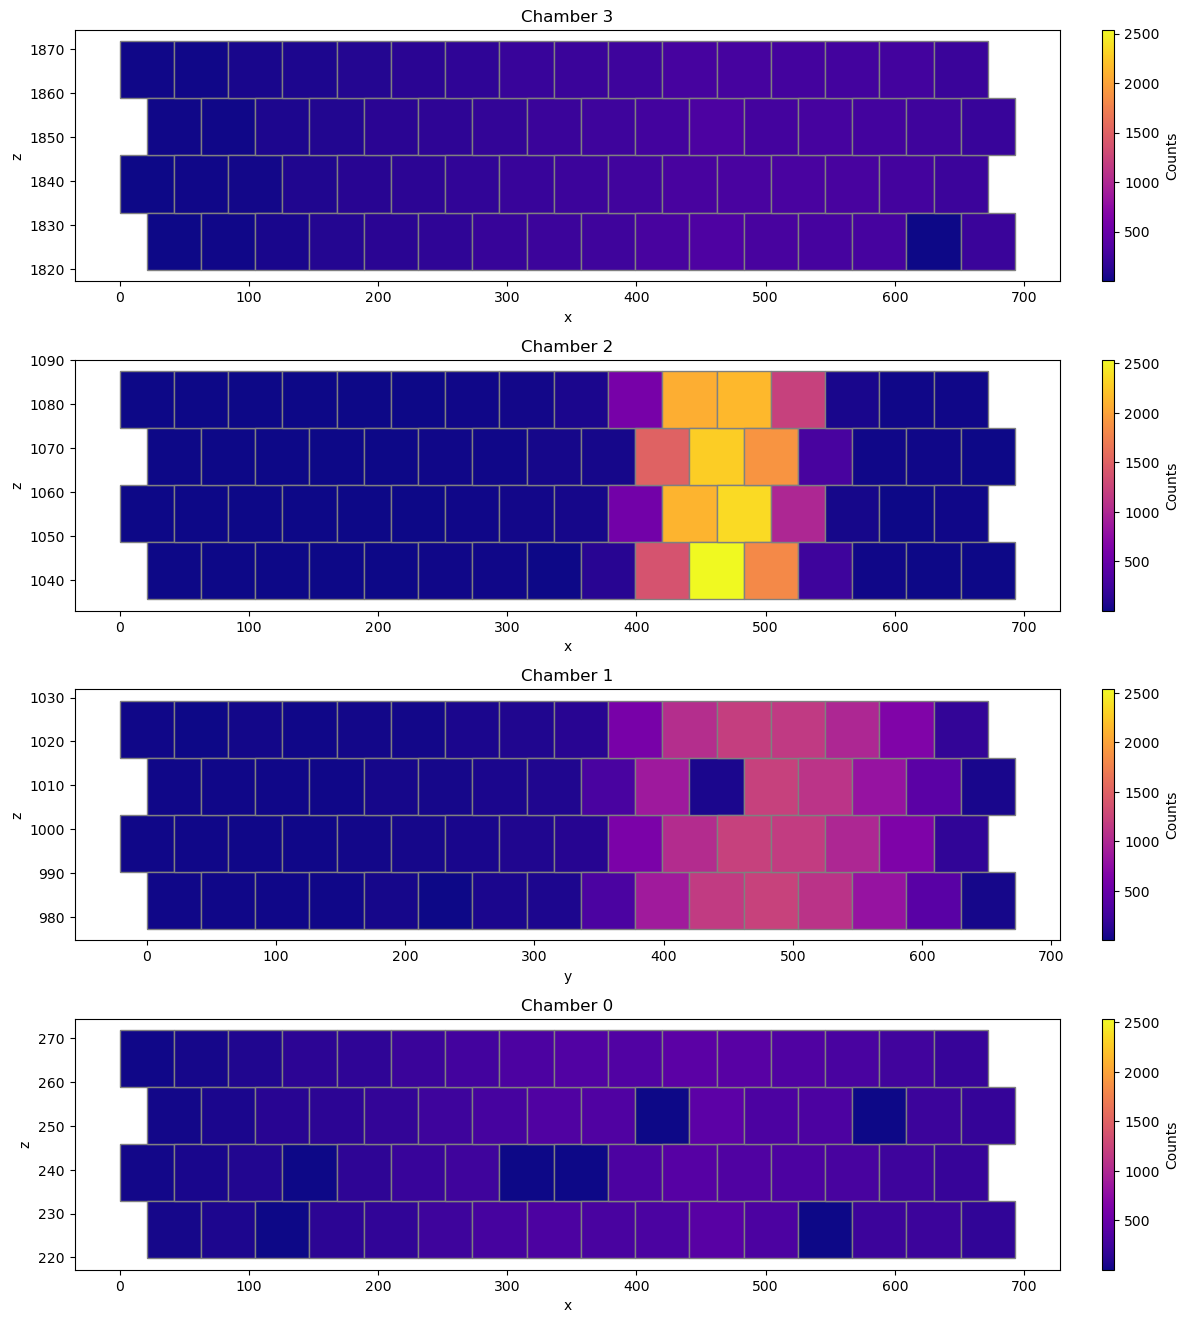

In [17]:
chambers = [3, 2, 1, 0]

plot_hit_counts(chambers, df_res, df_bricks)

### Local fits

In [18]:
warnings.filterwarnings('ignore')

regression_results_df = df_regression.compute()

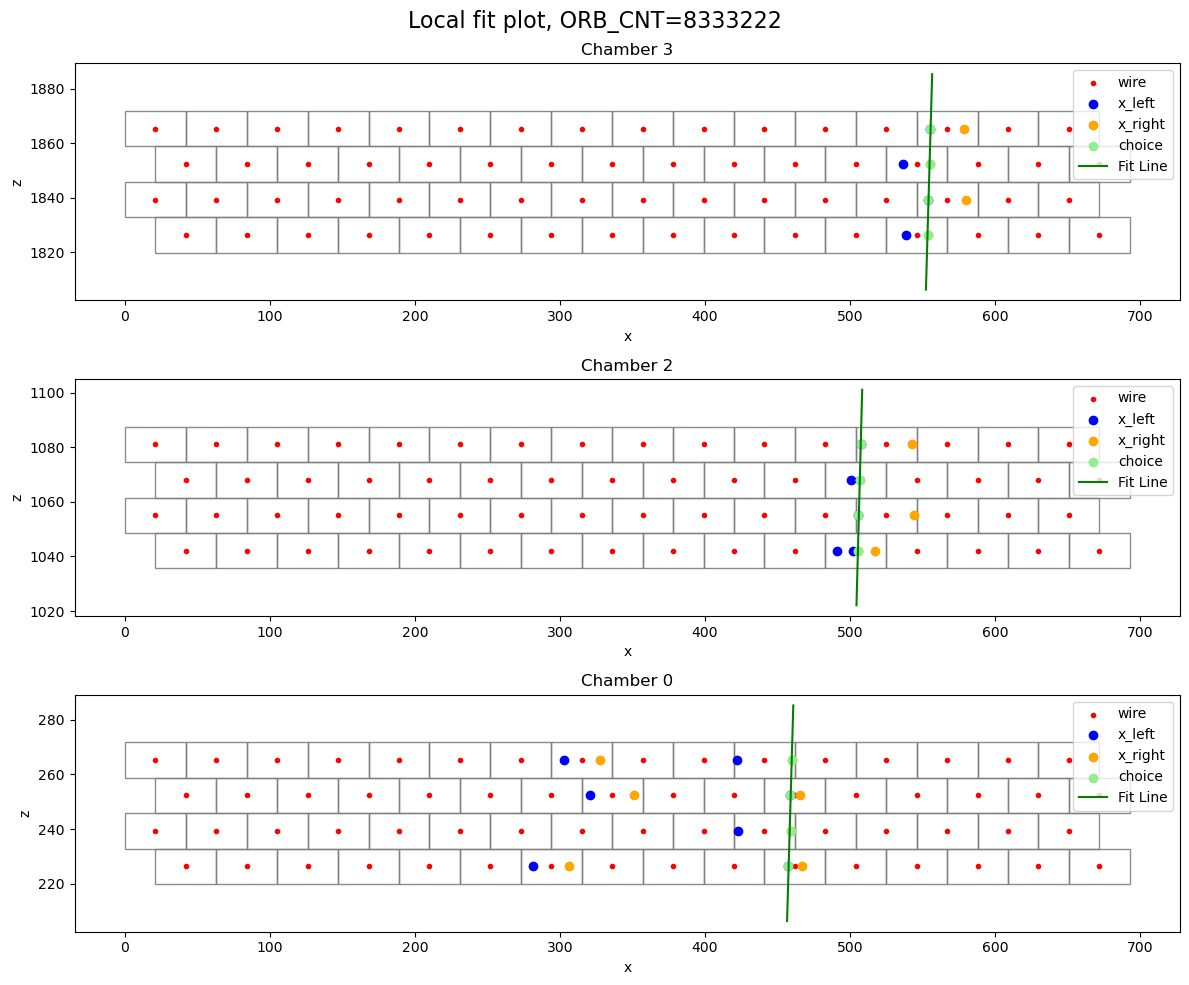

In [19]:
plot_local_fit(regression_results_df, df_res, n_orbit)

### Global fit plot

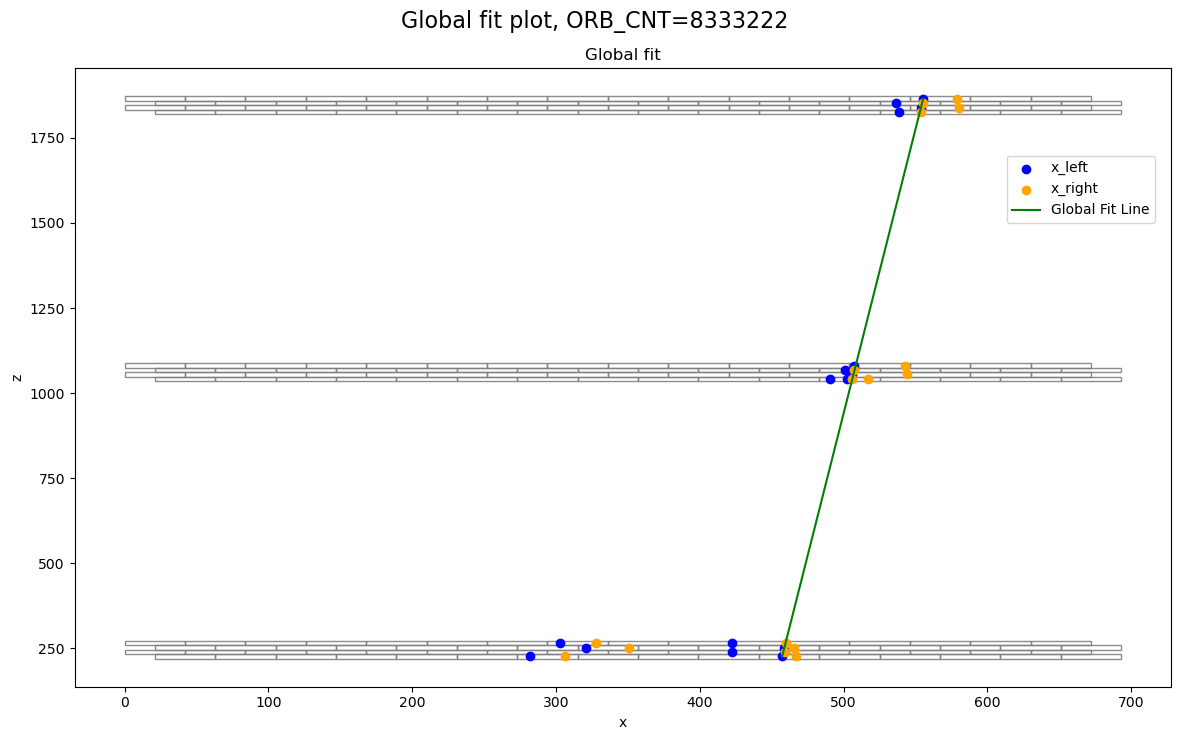

In [20]:
plot_global_fit(global_fit_df, df_res, n_orbit, df_bricks)

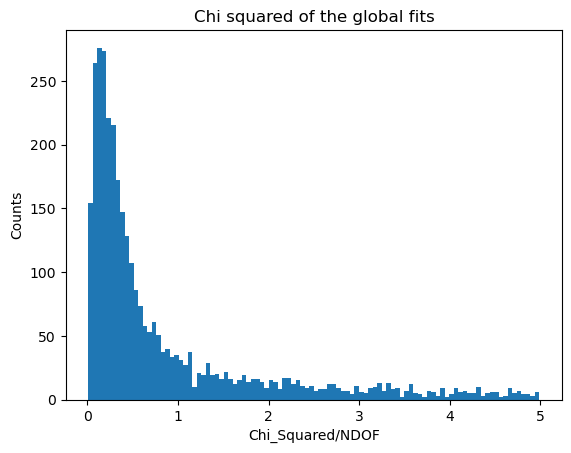

In [21]:
plt.hist(global_fit_df[global_fit_df['Chi_Squared_NDOF'] < 5]['Chi_Squared_NDOF'], bins=100, density=False)
plt.xlabel('Chi_Squared/NDOF')
plt.ylabel('Counts')
plt.title('Chi squared of the global fits')
plt.show()

# Whole dataset analysis

## Preprocessing, local and global fits

In [22]:
filename_all = 's3://project-bkp/data_0000*'

df_all = read_file(filename_all)
df_all = df_all.repartition(npartitions=n_partitions)
df_all = df_all.map_partitions(filter_groups_part1)
df_all = filter_groups_part2_a(df_all)
df_all = df_all.map_partitions(filter_groups_part2_b)

In [23]:
meta = pd.DataFrame({
    'Chamber_': pd.Series(dtype='int64'),
    'ORB_CNT_': pd.Series(dtype='uint64'),
    'x_values': pd.Series(dtype='object'),
    'z_values': pd.Series(dtype='object'),
    'Reg_Coefficient': pd.Series(dtype='float64'),
    'Reg_Intercept': pd.Series(dtype='float64'),
    'Chi_Squared_NDOF': pd.Series(dtype='float64')
})

df_regression_all = df_all.map_partitions(
    lambda partition: (
        partition
        .groupby(['Chamber', 'ORB_CNT'])
        .apply(fit_tracks_vectorized, include_groups=True)  # Use the vectorized version here
    ), 
    meta=meta).reset_index(drop=True).rename(columns={'Chamber_': 'Chamber', 'ORB_CNT_': 'ORB_CNT'})

#df_regression_all.visualize(True)

In [24]:
meta = pd.DataFrame({
    'ORB_CNT_': pd.Series(dtype='uint64'),
    'Reg_Coefficient': pd.Series(dtype='float64'),
    'Reg_Intercept':   pd.Series(dtype='float64'),
    'Chi_Squared_NDOF': pd.Series(dtype='float64')
})

global_tracks_df_all = df_regression_all.map_partitions(
    lambda partition: (
        partition
        .groupby(['ORB_CNT'])
        .apply(fit_global_tracks, include_groups=True)   
    ), 
    meta=meta).dropna().reset_index(drop=True).rename(columns={'ORB_CNT_': 'ORB_CNT'}).repartition(npartitions=1)

#global_tracks_df_all.visualize(True)

## Angular difference

In [25]:
global_fit_df_rn_all = global_tracks_df_all[global_tracks_df_all['Chi_Squared_NDOF'] < .7].rename(columns={'Reg_Coefficient':'Reg_Coefficient_glo', 'Reg_Intercept':'Reg_Intercept_glo'})
regression_results_df_ch2_rn_all = df_regression_all.rename(columns={'Chamber_':'Chamber', 'ORB_CNT_':'ORB_CNT', 'Reg_Coefficient':'Reg_Coefficient_loc', 'Reg_Intercept':'Reg_Intercept_loc'}).dropna()

In [26]:
df_ang_diff_all = global_fit_df_rn_all.merge(regression_results_df_ch2_rn_all, on = ['ORB_CNT'])

df_ang_diff_all['Angular difference'] = (np.arctan(df_ang_diff_all['Reg_Coefficient_glo']) - np.arctan(df_ang_diff_all['Reg_Coefficient_loc']))*180/np.pi

In [36]:
#df_ang_diff_all.visualize(True)

In [28]:
%%time
df_ang_diff_all_computed = df_ang_diff_all.compute()

CPU times: user 1.5 s, sys: 39.5 ms, total: 1.54 s
Wall time: 33.1 s


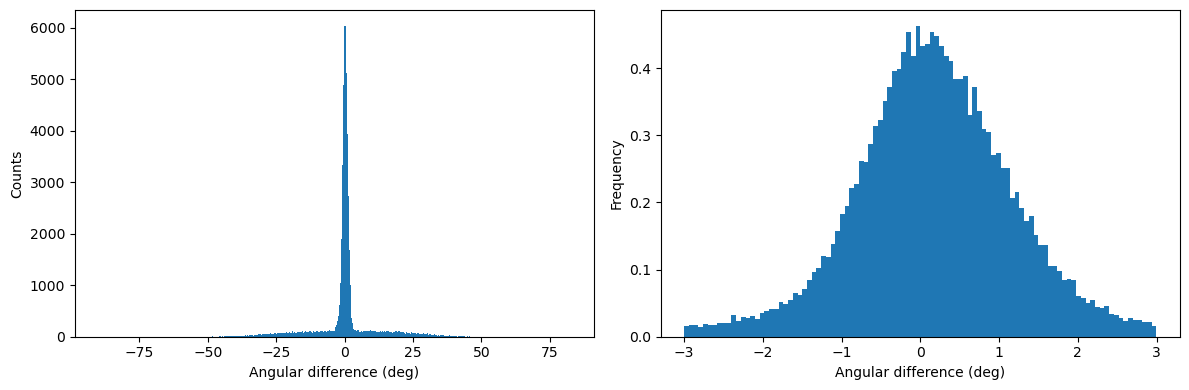

In [29]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))
axs[0].hist(df_ang_diff_all_computed['Angular difference'], bins=500)
axs[0].set_xlabel('Angular difference (deg)')
axs[0].set_ylabel('Counts')

mask_zoom = (df_ang_diff_all_computed['Angular difference'] > -3) & (df_ang_diff_all_computed['Angular difference'] < 3)

axs[1].hist(df_ang_diff_all_computed[mask_zoom]['Angular difference'], bins=100, density=True)
axs[1].set_xlabel('Angular difference (deg)')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [30]:
df_ang_diff_all_computed[mask_zoom]['Angular difference'].mean()

0.16434156673672018

In [31]:
df_ang_diff_all_computed[mask_zoom]['Angular difference'].std()

0.9871868266455953

## Stopping the client

In [32]:
end = time.time()

In [33]:
tot_min = int((end - start)/60)
tot_sec = (end - start) - 60*int((end - start)/60)
print(f'Total time: {tot_min:.0f} min {tot_sec:.0f} s')

Total time: 1 min 21 s


In [34]:
client.close()
cluster.close()